In [1]:
import pandas as pd
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment import SentimentIntensityAnalyzer
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import numpy as np

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\sven-\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


## Vader Analysis

In [2]:
vader = SentimentIntensityAnalyzer()

In [3]:
def analyze_vader(text):
    scores = vader.polarity_scores(text)
    return scores['compound']  # Main sentiment score [-1, 1]

def add_vader_sentiment(df, text_column='dialogue'):
    df['vader_sentiment'] = df[text_column].apply(analyze_vader)
    return df

## BERT

In [4]:
# === BERT Setup ===
model_name = "kornosk/polibertweet-mlm"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

def analyze_bert(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True)
    with torch.no_grad():
        logits = model(**inputs).logits
    probs = torch.nn.functional.softmax(logits, dim=-1).squeeze().numpy()
    return float(probs[1])  # Probability of positive sentiment

def add_bert_sentiment(df, text_column='dialogue'):
    df['bert_sentiment'] = (2*(df[text_column].apply(analyze_bert)))-1  # Scale to [-1, 1]
    return df

emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0


ModuleNotFoundError: Could not import module 'RobertaForSequenceClassification'. Are this object's requirements defined correctly?

## Comparison Values

In [5]:
def add_diff_sentiment(df, text_column='dialogue'):
    df = add_vader_sentiment(df, text_column)
    df = add_bert_sentiment(df, text_column)
    df['diff_sentiment'] = df['bert_sentiment'] - df['vader_sentiment']
    return df

## First Test

In [6]:
with open('debate_transcripts_cleaned.csv', 'r') as f:
    df = pd.read_csv(f)
#    df = add_diff_sentiment(df, text_column='dialogue')
#    df.to_csv('debate_transcripts_sentiment.csv', index=False)

In [ ]:
df.head()

,year,date,actor,dialogue,is_candidate,party,is_winner,VP_debate,is_incumbent,vader_sentiment,bert_sentiment,diff_sentiment
0,1960,1960-09-26,Kennedy,"Mr. Smith, Mr. Nixon. In the election of 1860,...",True,Democratic,True,False,False,0.9993,0.020701,-0.978599
1,1960,1960-09-26,Smith,And now the opening statement by Vice Presiden...,False,NaN,False,False,False,0.0000,0.038227,0.038227
2,1960,1960-09-26,Nixon,"Mr. Smith, Senator Kennedy. The things that Se...",True,Republican,False,False,False,0.9992,-0.001360,-1.000560
3,1960,1960-09-26,Smith,"Thank you, Mr. Nixon. That completes the openi...",False,NaN,False,False,False,0.3612,0.034914,-0.326286
4,1960,1960-09-26,Fleming,"Senator, the Vice President in his campaign ha...",False,NaN,False,False,False,-0.2732,0.088109,0.361309


In [7]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Download required NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Initialize lemmatizer and stopwords
lem = WordNetLemmatizer()
stop_words = stopwords.words('english')

def data_preprocess(text):
    # Tokenize text
    wtokens = word_tokenize(text)

    # Filtering tokens
    t_filtered = [t.lower() for t in wtokens if t.lower() not in stop_words and t.isalpha()]

    # Lemmatization
    t_lemmatized = [lem.lemmatize(t) for t in t_filtered]

    return " ".join(t_lemmatized)

# Apply preprocessing to the 'dialogue' column
df['cleaned_text'] = df['dialogue'].apply(data_preprocess)

# Display the first 15 entries of original and cleaned columns
df[['dialogue', 'cleaned_text']].head(15)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\sven-\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sven-\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\sven-\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,dialogue,cleaned_text
0,"Mr. Smith, Mr. Nixon. In the election of 1860,...",smith nixon election abraham lincoln said ques...
1,And now the opening statement by Vice Presiden...,opening statement vice president richard nixon
2,"Mr. Smith, Senator Kennedy. The things that Se...",smith senator kennedy thing senator kennedy sa...
3,"Thank you, Mr. Nixon. That completes the openi...",thank nixon completes opening statement candid...
4,"Senator, the Vice President in his campaign ha...",senator vice president campaign said naive tim...
5,"Well, the Vice President and I came to the Con...",well vice president came congress together ser...
6,"Mr. Nixon, would you like to comment on that s...",nixon would like comment statement
7,I have no comment.,comment
8,The next question: Mr. Novins.,next question novins
9,"Mr. Vice President, your campaign stresses the...",vice president campaign stress value eight yea...


In [9]:
df_vader = add_vader_sentiment(df, text_column='cleaned_text')

In [10]:
df_vader 

,year,date,actor,dialogue,is_candidate,party,is_winner,VP_debate,is_incumbent,cleaned_text,vader_sentiment
0,1960,1960-09-26,Kennedy,"Mr. Smith, Mr. Nixon. In the election of 1860,...",True,Democratic,True,False,False,smith nixon election abraham lincoln said ques...,0.9995
1,1960,1960-09-26,Smith,And now the opening statement by Vice Presiden...,False,NaN,False,False,False,opening statement vice president richard nixon,0.0000
2,1960,1960-09-26,Nixon,"Mr. Smith, Senator Kennedy. The things that Se...",True,Republican,False,False,False,smith senator kennedy thing senator kennedy sa...,0.9982
3,1960,1960-09-26,Smith,"Thank you, Mr. Nixon. That completes the openi...",False,NaN,False,False,False,thank nixon completes opening statement candid...,0.3612
4,1960,1960-09-26,Fleming,"Senator, the Vice President in his campaign ha...",False,NaN,False,False,False,senator vice president campaign said naive tim...,-0.2732
...,...,...,...,...,...,...,...,...,...,...,...
9928,2024,2024-10-01,Walz,"Well, thank you, Senator Vance. Thank you to C...",True,Democratic,False,True,False,well thank senator vance thank cbs news import...,0.9959
9929,2024,2024-10-01,Brennan,"Governor Walz. Thank you. Senator Vance, your ...",False,NaN,False,True,False,governor walz thank senator vance closing stat...,0.3612
9930,2024,2024-10-01,Vance,"Well, I want to thank Governor Walz, you folks...",True,Republican,True,True,False,well want thank governor walz folk cbs course ...,0.9950
9931,2024,2024-10-01,Brennan,"Senator Vance, thank you. And thank you both f...",False,NaN,False,True,False,senator vance thank thank participating vice p...,0.6124


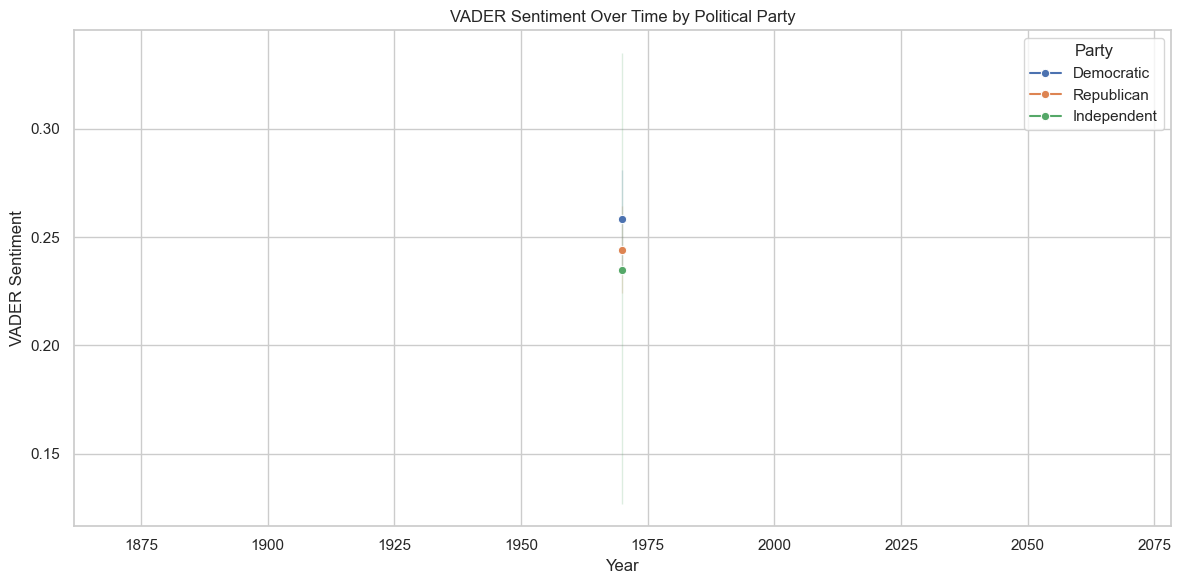

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

# Ensure the year column is of type int or datetime (if it's not already)
df_vader['year'] = pd.to_datetime(df_vader['year'], errors='coerce').dt.year

# Drop rows with missing years or sentiments (just in case)
df_plot = df_vader.dropna(subset=['year', 'vader_sentiment', 'party'])

# Set the plot style
sns.set(style='whitegrid')

# Create the plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_plot, x='year', y='vader_sentiment', hue='party', marker='o')

# Add labels and title
plt.title('VADER Sentiment Over Time by Political Party')
plt.xlabel('Year')
plt.ylabel('VADER Sentiment')
plt.legend(title='Party')
plt.tight_layout()
plt.show()